# GEM ML Framework Demonstrator - Deforestation Detection
In these notebooks, we provide an in-depth example of how the GEM ML framework can be used for segmenting deforested areas using Sentinel-2 imagery as input and the [TMF dataset](https://forobs.jrc.ec.europa.eu/TMF/) as a reference.
The idea is to use a neural network (NN) model for the analysis.
Thanks to the flexibility of the GEM ML framework, we can easily substitute the model in the future by adjusting only the configuration file.
We will have a look at the following notebooks separately:
- 00_Configuration
- 01_DataAcquisition
- 02_DataNormalization
- 03_TrainingValidationTesting
- 04_Inference_Clouds

Authors: Michael Engel (m.engel@tum.de) and Joana Reuss (joana.reuss@tum.de)

-----------------------------------------------------------------------------------

# Data Normalization
We want to normalize our data by using the often-used quantile scaling.
In order to receive the data distribution of the whole dataset, we merge the T-Digests we've created in the previous script for each `EOPatch`.
Based on that, we will store the desired quantiles for data normalization.

In [1]:
import os
import platform
import time

import matplotlib.pyplot as plt
import numpy as np

from libs.ConfigME import Config
from libs.MergeTDigests import mergeTDigests
from libs.QuantileScaler_eolearn import QuantileScaler_eolearn_tdigest
from utils.transforms import Torchify

from eolearn.core import FeatureType

print("Working Directory:", os.getcwd())

/home/michael/anaconda3/envs/eolearn_water/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Incorporating libs!
Incorporating tasks!
Incorporating utils!
Working Directory: /home/michael/Documents/GEM/TUM-Git/eo-learn-examples/GEM-ML/Example_DeforestationDetection
Environment: eolearn_water
Executable: /home/michael/anaconda3/envs/eolearn_water/bin/python


# Config
First, we load our configuration file which provides all information we need throughout the script and linuxify our paths (if you are working on a Windows machine) as the eo-learn filesystem manager does not support backslashes for now.

In [2]:
#%% load configuration file
config = Config.LOAD("config.dill")

#%% linuxify
config.linuxify()

# Merge T-Digests
Before we can normalize our dataset, we need to access our data's distribution.
The T-Digests can approximate cumulative distribution functions (CDF) without having the whole dataset in memory.
Accordingly, we can approximate the desired quantiles for normalization.

In [3]:
start = time.time()
tdigest = mergeTDigests(
    paths = [os.path.join(config["dir_train"],dir_) for dir_ in os.listdir(config["dir_train"])],
    feature = (FeatureType.SCALAR_TIMELESS, 'tdigest_data'),
    threads = 0 if platform.system()=="Windows" else config["threads"],
    checkthreads = True,
    bequiet = False
)
print(f"Merging of T-Digests took {time.time()-start:.2f}s using {config['threads']} thread(s)!")

ReduceME.reduce_BinaryTree: You are not calling this function from your main! Be aware that parallelization from within a spawned subprocess may cause severe resource issues!
1875/1875 calculations [100.00%] with 1 threads	
Merging of T-Digests took 154.71s using 5 thread(s)!


# Analyze T-Digests

__Sentinel-2 bands__: We are looking at the bands 2, 3, 4, 8, 11 and 12 of Sentinel-2.

In [4]:
bands = ["B02","B03","B04","B08","B11","B12"]

__Visualization__: Let's compute some quantiles for plotting the CDFs!

In [5]:
quantiless = []
xs = []
cdfs = []
for i in range(len(bands)):
    quantiless.append(np.array([tdigest[i].percentile(_) for _ in np.linspace(0,100,100)]))
    cdfs.append(np.array([tdigest[i].cdf(_) for _ in quantiless[-1]]))

Let's have a look at the resulting CDFs!
For clarity, we look at a 96% interval, namely from 2% to 98% of our ordered dataset.

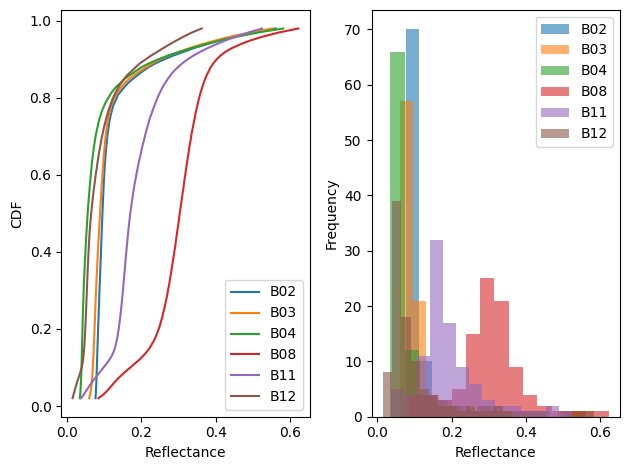

In [6]:
cidx = 2
plt.figure()
plt.subplot(121)
for i, band in enumerate(bands):
    plt.plot(quantiless[i][cidx:-cidx],cdfs[i][cidx:-cidx],label=band)

plt.xlabel("Reflectance")
plt.ylabel("CDF")
plt.legend()

plt.subplot(122)
for i, band in enumerate(bands):
    plt.hist(quantiless[i][cidx:-cidx],bins=int(np.sqrt(96)*1.5),ec=None,alpha=0.6,label=band)
plt.xlabel("Reflectance")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()

We see that the respective bands are distributed within different ranges.
Hence, it is crucial for machine learning to normalize all of them.
For that purpose, we store the T-Digest on disk for later use in our ML pipeline!

In [7]:
np.save(os.path.join(config["dir_results"],config["savename_tdigest"]),tdigest)

# Quantile Scaling
As discussed, we want to apply quantile scaling to our data.
We already merged the separate T-Digests to one and stored the result on disk.
Note that only the training samples have been used for that.

Since PyTorch asks for inputs having shape `[batch_size x channels x timestamps x height x width]`, we need to reshape the data features accordingly.
Fortunately, the __`QuantileScaler_eolearn_tdigest`__ can handle this by setting `transform=True`.

However, for our current use case, we do not need a temporal component - neither for the input data nor the reference.
Hence, we will use the class __`Torchify`__ as provided within the __`Dataset_eolearn`__ module.
It allows us to squeeze the temporal dimension.

In [8]:
Scaler = QuantileScaler_eolearn_tdigest(
    tdigestarray = tdigest,
    minquantile = config["scaler_minquantile"],
    maxquantile = config["scaler_maxquantile"],
    nanval = config["scaler_nanval"],
    infval = config["scaler_infval"],
    valmin = config["scaler_valmin"],
    valmax = config["scaler_valmax"],
    transform = Torchify(1),
    savename = os.path.join(config["dir_results"],config["savename_scaler"])
)

__Let's see whether it worked!__

First, we have to transform our quantiles.
Note that this transformation is a little hacky because we have neither height nor width as we would with our `EOPatches`.

In [9]:
quantiles = np.stack(quantiless,axis=-1)
quantiles_transformed = Scaler(quantiles).T

Let's visualize our numeric window in the distribution of our data!

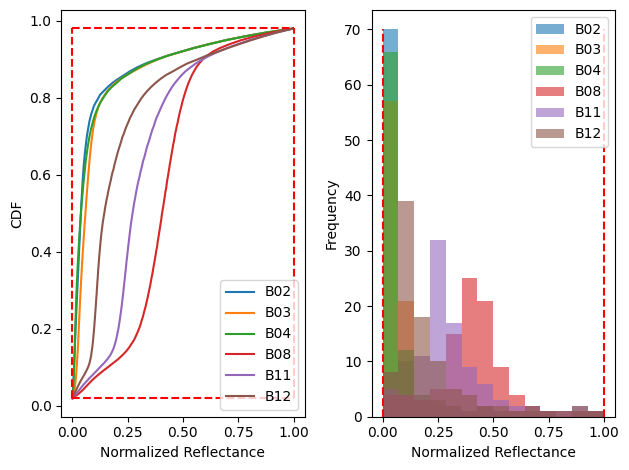

In [10]:
plt.figure()
plt.subplot(121)
for i, band in enumerate(bands):
    plt.plot(quantiles_transformed[cidx:-cidx,i],cdfs[i][cidx:-cidx],label=band)
plt.hlines([Scaler.minquantile,Scaler.maxquantile],Scaler.valmin,Scaler.valmax,colors='r',linestyles='--')
plt.vlines([Scaler.valmin,Scaler.valmax],Scaler.minquantile,Scaler.maxquantile,colors='r',linestyles='--')

plt.xlabel("Normalized Reflectance")
plt.ylabel("CDF")
plt.legend()

plt.subplot(122)
hists = []
for i, band in enumerate(bands):
    hists.append(plt.hist(quantiles_transformed[cidx:-cidx,i],bins=int(np.sqrt(96)*1.5),ec=None,alpha=0.6,label=band))
plt.vlines([Scaler.valmin,Scaler.valmax],0,np.max([hist[0].max() for hist in hists]),colors='r',linestyles='--')

plt.xlabel("Normalized Reflectance")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()

Down the river, we have to use our scaler again.
Hence, we store it to disk.

In [11]:
Scaler.save()

'/home/michael/Documents/GEM/TUM-Git/eo-learn-examples/GEM-ML/Example_DeforestationDetection/DeforestationDetectionRun/results/DeforestationDetectionRun_QuantileScaler.dill'